In [1]:
import tensorflow as tf
import os
from utils import *
from tqdm import tqdm

In [2]:
attention_win_size = 3
max_N = 180
max_T = 210

def guided_attention(g=0.2):
    W = np.zeros((max_N, max_T), dtype=np.float32)
    for n_pos in range(W.shape[0]):
        for t_pos in range(W.shape[1]):
            W[n_pos, t_pos] = 1 - np.exp(-(t_pos / float(max_T) - n_pos / float(max_N)) ** 2 / (2 * g * g))
    return W

In [3]:
def Attention(Q, K, V, d, mononotic_attention=False, prev_max_attentions=None):
    A = tf.matmul(Q, K, transpose_b=True) * tf.rsqrt(tf.to_float(d))
    T = tf.shape(Q)[1]
    N = tf.shape(K)[1]
    if mononotic_attention:
        key_masks = tf.sequence_mask(prev_max_attentions, N)
        reverse_masks = tf.sequence_mask(N - attention_win_size - prev_max_attentions, N)[:, ::-1]
        masks = tf.logical_or(key_masks, reverse_masks)
        masks = tf.tile(tf.expand_dims(masks, 1), [1, T, 1])
        paddings = tf.ones_like(A) * (-2 ** 32 + 1)
        A = tf.where(tf.equal(masks, False), A, paddings)
    A = tf.nn.softmax(A)
    max_attentions = tf.argmax(A, -1)
    R = tf.matmul(A, V)
    R = tf.concat((R, Q), -1)

    alignments = tf.transpose(A, [0, 2, 1])

    return R, alignments, max_attentions

def layer_norm(inputs, epsilon=1e-8):
    mean, variance = tf.nn.moments(inputs, [-1], keep_dims=True)
    normalized = (inputs - mean) / (tf.sqrt(variance + epsilon))
    params_shape = inputs.get_shape()[-1:]
    gamma = tf.get_variable('gamma', params_shape, tf.float32, tf.ones_initializer())
    beta = tf.get_variable('beta', params_shape, tf.float32, tf.zeros_initializer())
    return gamma * normalized + beta


def cnn_block(x, dilation_rate, pad_sz, hidden_dim, kernel_size):
    x = layer_norm(x)
    pad = tf.zeros([tf.shape(x)[0], pad_sz, hidden_dim])
    x =  tf.layers.conv1d(inputs = tf.concat([pad, x, pad], 1),
                          filters = hidden_dim,
                          kernel_size = kernel_size,
                          dilation_rate = dilation_rate)
    x = x[:, :-pad_sz, :]
    x = tf.nn.relu(x)
    return x

def hc(inputs,
       filters=None,
       size=1,
       rate=1,
       padding="SAME",
       dropout_rate=0,
       use_bias=True,
       activation_fn=None,
       training=True,
       scope="hc",
       reuse=None):
    _inputs = inputs
    with tf.variable_scope(scope):
        if padding.lower() == "causal":
            pad_len = (size - 1) * rate
            inputs = tf.pad(inputs, [[0, 0], [pad_len, 0], [0, 0]])
            padding = "valid"

        if filters is None:
            filters = inputs.get_shape().as_list()[-1]


        params = {"inputs": inputs, "filters": 2*filters, "kernel_size": size,
                  "dilation_rate": rate, "padding": padding, "use_bias": use_bias,
                  "kernel_initializer": tf.contrib.layers.variance_scaling_initializer(), "reuse": reuse}

        tensor = tf.layers.conv1d(**params)
        H1, H2 = tf.split(tensor, 2, axis=-1)
        with tf.variable_scope('h1'):
            H1 = layer_norm(H1)
        with tf.variable_scope('h2'):
            H2 = layer_norm(H2)
        H1 = tf.nn.sigmoid(H1, "gate")
        H2 = activation_fn(H2, "info") if activation_fn is not None else H2
        tensor = H1*H2 + (1.-H1)*_inputs

    return tensor

class Model:
    def __init__(
        self,
        num_layers,
        size_layers,
        learning_rate = 1e-4,
        kernel_size = 5
    ):
        self.X = tf.placeholder(tf.int32, (None, None))
        lookup_table = tf.get_variable(
            'lookup_table',
            dtype = tf.float32,
            shape = [len(vocab), size_layers],
            initializer = tf.truncated_normal_initializer(
                mean = 0.0, stddev = 0.01
            ),
        )
        lookup_table = tf.concat(
            (tf.zeros(shape = [1, size_layers]), lookup_table[1:, :]), 0
        )
        self.gts = tf.convert_to_tensor(guided_attention())
        forward = tf.nn.embedding_lookup(lookup_table, self.X)
        self.Y = tf.placeholder(tf.float32, (None, None, n_mels * resampled))
        batch_size = tf.shape(self.Y)[0]
        self.decoder_inputs = tf.concat(
            (tf.ones_like(self.Y[:, :1, :]), self.Y[:, :-1, :]), 1
        )
        self.decoder_inputs = self.decoder_inputs[:, :, -n_mels:]
        
        self.Z = tf.placeholder(
            tf.float32, (None, None, fourier_window_size // 2 + 1)
        )
        self.prev_max_attentions = tf.placeholder(tf.int32, shape=(1,))
        forward = tf.concat([forward, forward], 2)
        
        for i in range(num_layers): 
            dilation_rate = 2 ** i
            pad_sz = (kernel_size - 1) * dilation_rate 
            with tf.variable_scope('block_%d'%i):
                forward += cnn_block(forward, dilation_rate, pad_sz, size_layers * 2, kernel_size)
                forward = hc(forward)
        
        K, V = tf.split(forward, 2, -1)
                
        encoder = tf.layers.dense(self.decoder_inputs, size_layers)
        
        for i in range(num_layers): 
            dilation_rate = 2 ** i
            pad_sz = (kernel_size - 1) * dilation_rate 
            with tf.variable_scope('block_encoder_%d'%i):
                encoder += cnn_block(encoder, dilation_rate, pad_sz, size_layers, kernel_size)
        
        train_R, self.alignments, train_max_attentions = Attention(encoder, K, V, size_layers,
                                                                 mononotic_attention=False,
                                                                 prev_max_attentions=self.prev_max_attentions)
        
        test_R, _, self.max_attentions = Attention(encoder, K, V, size_layers,
                                                                 mononotic_attention=True,
                                                                 prev_max_attentions=self.prev_max_attentions)
        
        print(train_R)
        
        def generate_mel(x, reuse = False):
            with tf.variable_scope('generate_mel', reuse = reuse):
                for i in range(num_layers): 
                    dilation_rate = 2 ** i
                    pad_sz = (kernel_size - 1) * dilation_rate 
                    with tf.variable_scope('block_mel_%d'%i, reuse = reuse):
                        x += cnn_block(x, dilation_rate, pad_sz, size_layers * 2, kernel_size)
                return tf.layers.dense(x, n_mels * resampled)
        
        self.train_Y_logits = generate_mel(train_R)
        self.test_Y_logits = generate_mel(test_R, reuse = True)
        self.train_Y_hat = tf.sigmoid(self.train_Y_logits)
        self.test_Y_hat = tf.sigmoid(self.test_Y_logits)
        
        self.loss1 = tf.reduce_mean(tf.abs(self.train_Y_hat - self.Y))
        self.loss_bd1 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=self.train_Y_logits, 
                                                                               labels=self.Y))
        self.A = tf.pad(self.alignments, [(0, 0), (0, max_N), (0, max_T)], 
                        mode="CONSTANT", constant_values=-1.)[:, :max_N, :max_T]
        self.attention_masks = tf.to_float(tf.not_equal(self.A, -1))
        self.loss_att = tf.reduce_sum(tf.abs(self.A * self.gts) * self.attention_masks)
        self.mask_sum = tf.reduce_sum(self.attention_masks)
        self.loss_att /= self.mask_sum
        
        out_decoder = tf.reshape(
                self.Y, [tf.shape(self.Y)[0], -1, n_mels]
        )
        out_decoder = tf.layers.dense(out_decoder, size_layers)
        
        for i in range(num_layers): 
            dilation_rate = 2 ** i
            pad_sz = (kernel_size - 1) * dilation_rate 
            with tf.variable_scope('block_vocoder_%d'%i):
                out_decoder += cnn_block(out_decoder, dilation_rate, pad_sz, size_layers, kernel_size)
        
        self.Z_logits = tf.layers.dense(out_decoder, 1 + fourier_window_size // 2)
        self.Z_hat = tf.sigmoid(self.Z_logits)
        self.loss2 = tf.reduce_mean(tf.abs(self.Z_hat - self.Z))
        self.loss_bd2 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=self.Z_logits, 
                                                                          labels=self.Z))
        self.loss = self.loss1 + self.loss2 + self.loss_bd1 + self.loss_bd2 + self.loss_att
        self.optimizer = tf.train.AdamOptimizer(
            learning_rate = learning_rate
        ).minimize(self.loss)

In [4]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

size_layers = 128
learning_rate = 1e-4
num_layers = 4

model = Model(num_layers, size_layers, learning_rate)
sess.run(tf.global_variables_initializer())

Tensor("concat_4:0", shape=(?, ?, 256), dtype=float32)


In [5]:
paths, lengths, texts, raw_texts = [], [], [], []
text_files = [f for f in os.listdir('mel') if f.endswith('.npy')]
for fpath in text_files:
    with open('%s/%s' % (path, fpath.replace('npy', 'txt'))) as fopen:
        text = fopen.read()
    paths.append(fpath.replace('.npy', ''))
    text = text_normalize(text)
    raw_texts.append(text)
    text = text + 'E'
    texts.append(np.array([char2idx[char] for char in text], np.int32))
    lengths.append(len(text))

In [6]:
def dynamic_batching(paths):
    files, max_y, max_z = [], 0, 0
    for n in range(len(paths)):
        files.append(get_cached(paths[n]))
        if files[-1][0].shape[0] > max_y:
            max_y = files[-1][0].shape[0]
        if files[-1][1].shape[0] > max_z:
            max_z = files[-1][1].shape[0]
    return files, max_y, max_z

minibatch loop: 100%|██████████| 88/88 [00:27<00:00,  1.95it/s, cost=0.776, loss1=0.0993, loss2=0.0732, loss_att=0.0031, loss_bd1=0.286, loss_bd2=0.314]


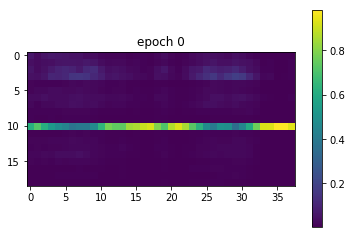

minibatch loop: 100%|██████████| 88/88 [00:14<00:00,  6.45it/s, cost=0.62, loss1=0.0529, loss2=0.046, loss_att=0.00264, loss_bd1=0.232, loss_bd2=0.286]  


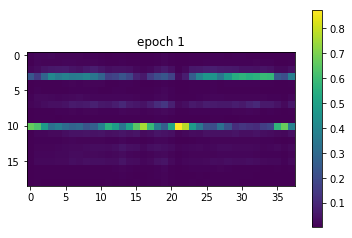

minibatch loop: 100%|██████████| 88/88 [00:14<00:00,  6.47it/s, cost=0.591, loss1=0.0438, loss2=0.04, loss_att=0.00252, loss_bd1=0.223, loss_bd2=0.282]  


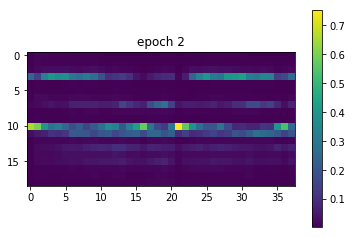

minibatch loop: 100%|██████████| 88/88 [00:14<00:00,  6.43it/s, cost=0.578, loss1=0.04, loss2=0.037, loss_att=0.00236, loss_bd1=0.219, loss_bd2=0.279]   


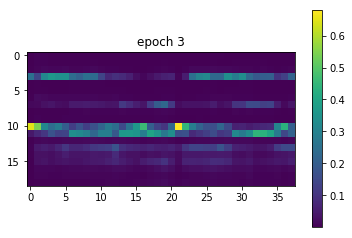

minibatch loop: 100%|██████████| 88/88 [00:14<00:00,  6.38it/s, cost=0.57, loss1=0.0377, loss2=0.0349, loss_att=0.00221, loss_bd1=0.217, loss_bd2=0.278] 


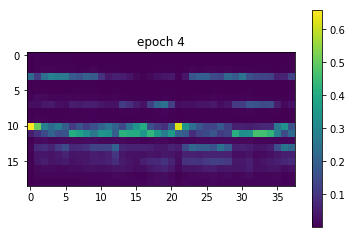

minibatch loop: 100%|██████████| 88/88 [00:14<00:00,  6.36it/s, cost=0.565, loss1=0.0364, loss2=0.0335, loss_att=0.00211, loss_bd1=0.216, loss_bd2=0.277]


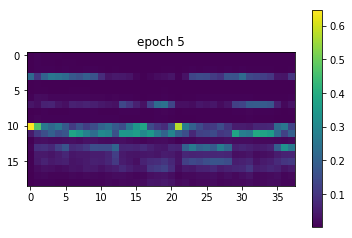

minibatch loop: 100%|██████████| 88/88 [00:14<00:00,  6.41it/s, cost=0.562, loss1=0.0352, loss2=0.0324, loss_att=0.00204, loss_bd1=0.215, loss_bd2=0.277]


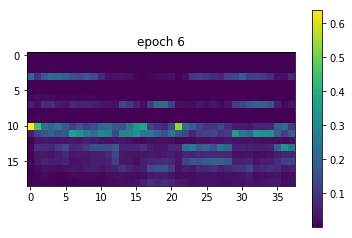

minibatch loop: 100%|██████████| 88/88 [00:14<00:00,  6.35it/s, cost=0.559, loss1=0.0344, loss2=0.0316, loss_att=0.00195, loss_bd1=0.215, loss_bd2=0.276]


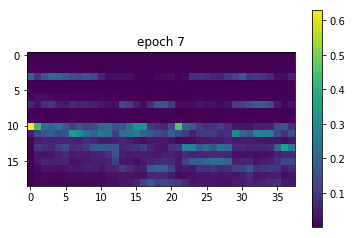

minibatch loop: 100%|██████████| 88/88 [00:14<00:00,  6.45it/s, cost=0.556, loss1=0.0336, loss2=0.031, loss_att=0.00188, loss_bd1=0.214, loss_bd2=0.276] 


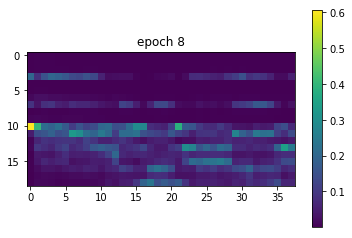

minibatch loop: 100%|██████████| 88/88 [00:14<00:00,  6.41it/s, cost=0.554, loss1=0.0329, loss2=0.0306, loss_att=0.00185, loss_bd1=0.213, loss_bd2=0.276]


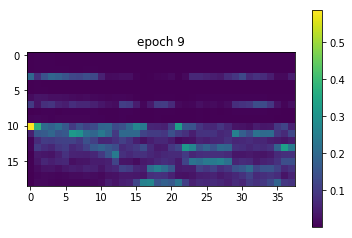

minibatch loop: 100%|██████████| 88/88 [00:14<00:00,  6.37it/s, cost=0.552, loss1=0.0323, loss2=0.0301, loss_att=0.00163, loss_bd1=0.213, loss_bd2=0.275]


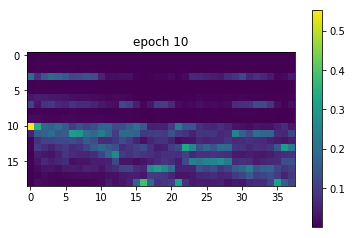

minibatch loop: 100%|██████████| 88/88 [00:14<00:00,  6.47it/s, cost=0.551, loss1=0.0317, loss2=0.0297, loss_att=0.00159, loss_bd1=0.213, loss_bd2=0.275]


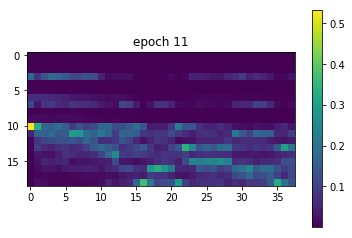

minibatch loop: 100%|██████████| 88/88 [00:14<00:00,  6.45it/s, cost=0.549, loss1=0.0311, loss2=0.0292, loss_att=0.00157, loss_bd1=0.212, loss_bd2=0.275]


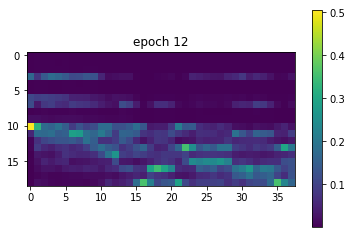

minibatch loop: 100%|██████████| 88/88 [00:14<00:00,  6.46it/s, cost=0.547, loss1=0.0306, loss2=0.0289, loss_att=0.00154, loss_bd1=0.212, loss_bd2=0.275]


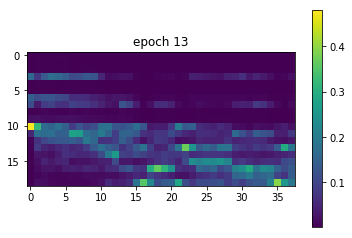

minibatch loop: 100%|██████████| 88/88 [00:14<00:00,  6.46it/s, cost=0.546, loss1=0.0301, loss2=0.0285, loss_att=0.00152, loss_bd1=0.211, loss_bd2=0.275]


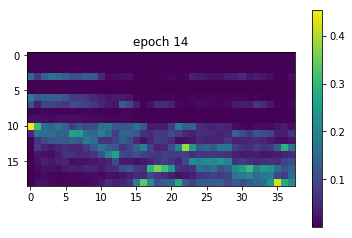

minibatch loop: 100%|██████████| 88/88 [00:14<00:00,  6.45it/s, cost=0.545, loss1=0.0296, loss2=0.0282, loss_att=0.0015, loss_bd1=0.211, loss_bd2=0.274] 


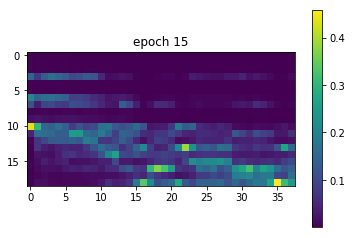

minibatch loop: 100%|██████████| 88/88 [00:14<00:00,  6.44it/s, cost=0.543, loss1=0.0291, loss2=0.0279, loss_att=0.00148, loss_bd1=0.211, loss_bd2=0.274]


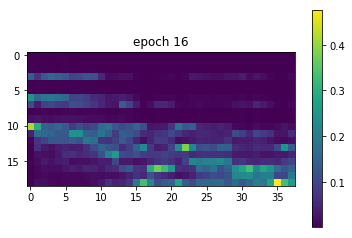

minibatch loop: 100%|██████████| 88/88 [00:14<00:00,  6.46it/s, cost=0.542, loss1=0.0287, loss2=0.0276, loss_att=0.00147, loss_bd1=0.21, loss_bd2=0.274] 


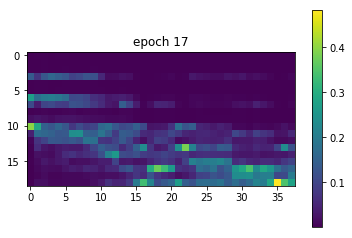

minibatch loop: 100%|██████████| 88/88 [00:14<00:00,  6.46it/s, cost=0.541, loss1=0.0283, loss2=0.0274, loss_att=0.00145, loss_bd1=0.21, loss_bd2=0.274] 


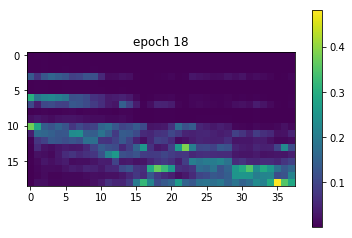

minibatch loop: 100%|██████████| 88/88 [00:14<00:00,  6.40it/s, cost=0.54, loss1=0.028, loss2=0.0272, loss_att=0.00143, loss_bd1=0.21, loss_bd2=0.274]   


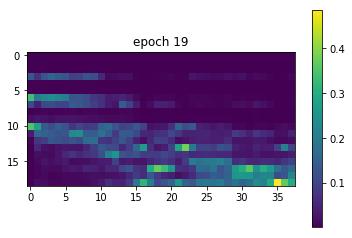

minibatch loop: 100%|██████████| 88/88 [00:14<00:00,  6.46it/s, cost=0.539, loss1=0.0277, loss2=0.027, loss_att=0.00142, loss_bd1=0.21, loss_bd2=0.274]  


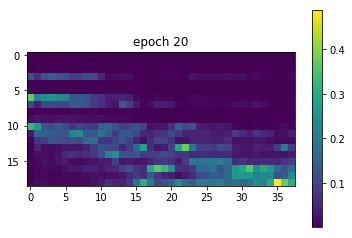

minibatch loop: 100%|██████████| 88/88 [00:14<00:00,  6.46it/s, cost=0.538, loss1=0.0274, loss2=0.0268, loss_att=0.0014, loss_bd1=0.209, loss_bd2=0.274] 


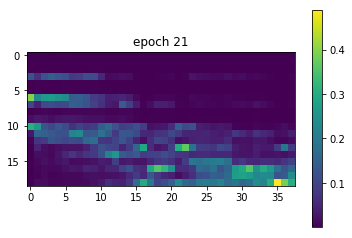

minibatch loop: 100%|██████████| 88/88 [00:14<00:00,  6.46it/s, cost=0.538, loss1=0.0271, loss2=0.0266, loss_att=0.00138, loss_bd1=0.209, loss_bd2=0.274]


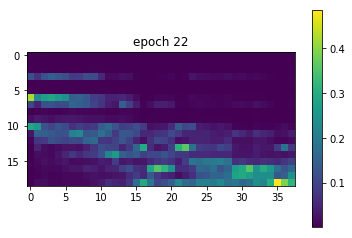

minibatch loop: 100%|██████████| 88/88 [00:14<00:00,  6.47it/s, cost=0.537, loss1=0.0268, loss2=0.0264, loss_att=0.00137, loss_bd1=0.209, loss_bd2=0.273]


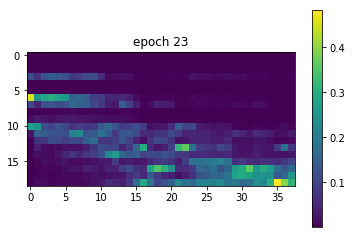

minibatch loop: 100%|██████████| 88/88 [00:14<00:00,  6.47it/s, cost=0.536, loss1=0.0266, loss2=0.0262, loss_att=0.00147, loss_bd1=0.209, loss_bd2=0.273]


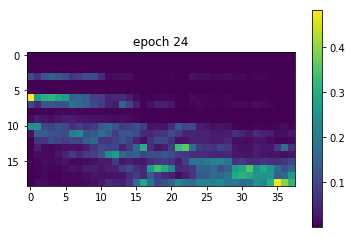

minibatch loop: 100%|██████████| 88/88 [00:14<00:00,  6.48it/s, cost=0.536, loss1=0.0264, loss2=0.0261, loss_att=0.00139, loss_bd1=0.209, loss_bd2=0.273]


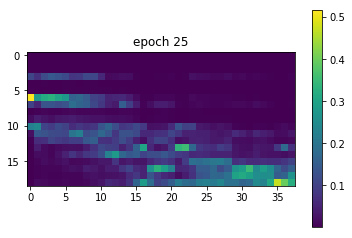

minibatch loop: 100%|██████████| 88/88 [00:14<00:00,  6.35it/s, cost=0.535, loss1=0.0262, loss2=0.0259, loss_att=0.00134, loss_bd1=0.208, loss_bd2=0.273]


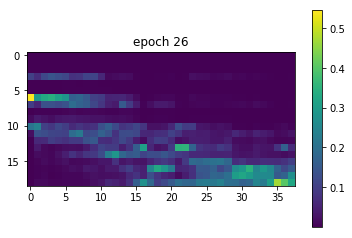

minibatch loop: 100%|██████████| 88/88 [00:14<00:00,  6.46it/s, cost=0.535, loss1=0.026, loss2=0.0257, loss_att=0.00136, loss_bd1=0.208, loss_bd2=0.273] 


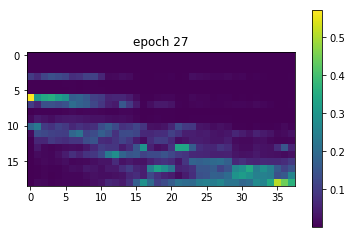

minibatch loop: 100%|██████████| 88/88 [00:14<00:00,  6.38it/s, cost=0.534, loss1=0.0258, loss2=0.0256, loss_att=0.00134, loss_bd1=0.208, loss_bd2=0.273]


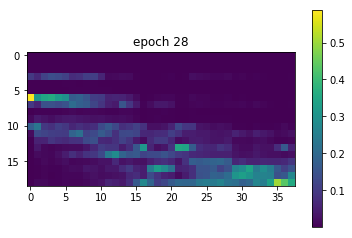

minibatch loop: 100%|██████████| 88/88 [00:14<00:00,  6.47it/s, cost=0.534, loss1=0.0257, loss2=0.0255, loss_att=0.00139, loss_bd1=0.208, loss_bd2=0.273]


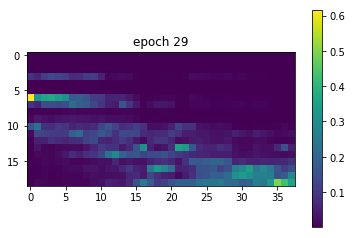

minibatch loop: 100%|██████████| 88/88 [00:14<00:00,  6.46it/s, cost=0.533, loss1=0.0255, loss2=0.0253, loss_att=0.00136, loss_bd1=0.208, loss_bd2=0.273]


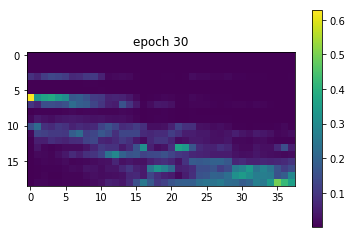

minibatch loop: 100%|██████████| 88/88 [00:14<00:00,  6.42it/s, cost=0.533, loss1=0.0253, loss2=0.0252, loss_att=0.0013, loss_bd1=0.208, loss_bd2=0.273] 


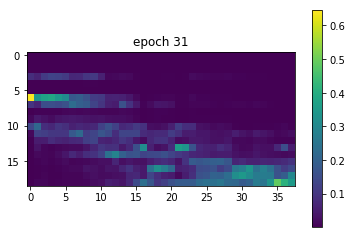

minibatch loop: 100%|██████████| 88/88 [00:14<00:00,  6.48it/s, cost=0.532, loss1=0.0252, loss2=0.0251, loss_att=0.00132, loss_bd1=0.208, loss_bd2=0.273]


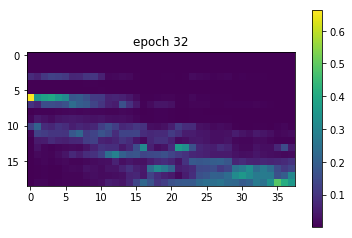

minibatch loop: 100%|██████████| 88/88 [00:14<00:00,  6.48it/s, cost=0.532, loss1=0.025, loss2=0.0249, loss_att=0.00138, loss_bd1=0.208, loss_bd2=0.273] 


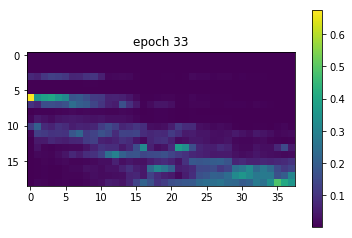

minibatch loop: 100%|██████████| 88/88 [00:14<00:00,  6.44it/s, cost=0.531, loss1=0.0249, loss2=0.0248, loss_att=0.00136, loss_bd1=0.208, loss_bd2=0.273]


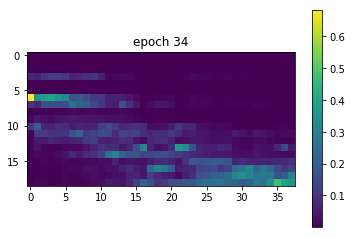

minibatch loop: 100%|██████████| 88/88 [00:14<00:00,  6.38it/s, cost=0.531, loss1=0.0248, loss2=0.0247, loss_att=0.00131, loss_bd1=0.207, loss_bd2=0.273]


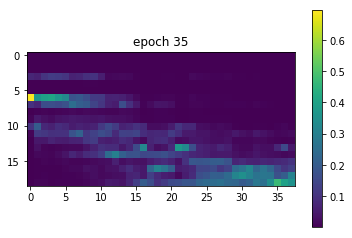

minibatch loop: 100%|██████████| 88/88 [00:14<00:00,  6.46it/s, cost=0.53, loss1=0.0246, loss2=0.0246, loss_att=0.00122, loss_bd1=0.207, loss_bd2=0.273] 


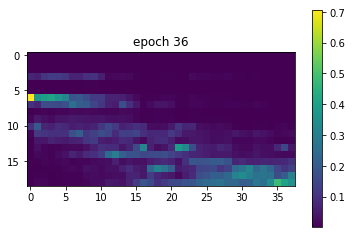

minibatch loop: 100%|██████████| 88/88 [00:14<00:00,  6.47it/s, cost=0.53, loss1=0.0245, loss2=0.0244, loss_att=0.00119, loss_bd1=0.207, loss_bd2=0.273] 


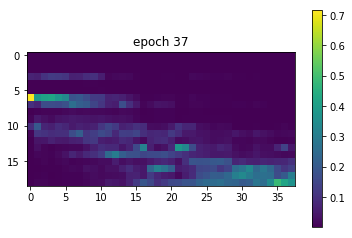

minibatch loop: 100%|██████████| 88/88 [00:14<00:00,  6.44it/s, cost=0.53, loss1=0.0245, loss2=0.0243, loss_att=0.00123, loss_bd1=0.207, loss_bd2=0.273] 


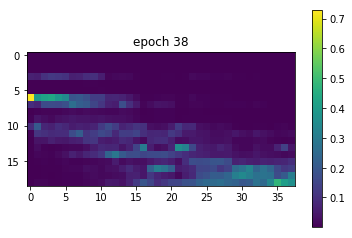

minibatch loop: 100%|██████████| 88/88 [00:14<00:00,  6.35it/s, cost=0.53, loss1=0.0243, loss2=0.0242, loss_att=0.00146, loss_bd1=0.207, loss_bd2=0.272] 


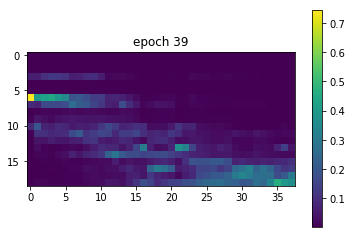

minibatch loop: 100%|██████████| 88/88 [00:14<00:00,  6.34it/s, cost=0.529, loss1=0.0242, loss2=0.0241, loss_att=0.00133, loss_bd1=0.207, loss_bd2=0.272]


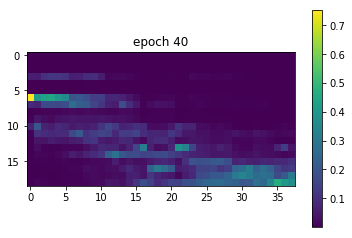

minibatch loop: 100%|██████████| 88/88 [00:14<00:00,  6.34it/s, cost=0.529, loss1=0.024, loss2=0.024, loss_att=0.00126, loss_bd1=0.207, loss_bd2=0.272]  


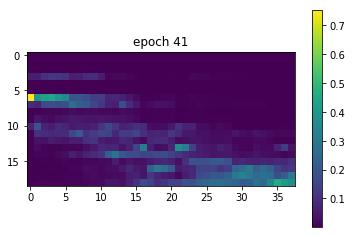

minibatch loop: 100%|██████████| 88/88 [00:14<00:00,  6.46it/s, cost=0.528, loss1=0.0239, loss2=0.0239, loss_att=0.00122, loss_bd1=0.207, loss_bd2=0.272]


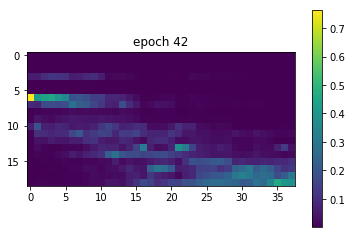

minibatch loop: 100%|██████████| 88/88 [00:14<00:00,  6.44it/s, cost=0.528, loss1=0.0238, loss2=0.0238, loss_att=0.00129, loss_bd1=0.207, loss_bd2=0.272]


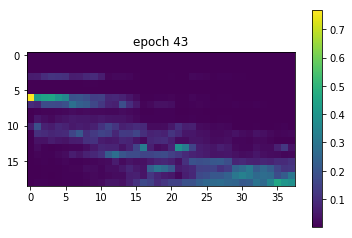

minibatch loop: 100%|██████████| 88/88 [00:14<00:00,  6.34it/s, cost=0.528, loss1=0.0238, loss2=0.0237, loss_att=0.00118, loss_bd1=0.207, loss_bd2=0.272]


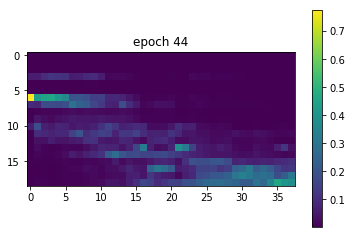

minibatch loop: 100%|██████████| 88/88 [00:14<00:00,  6.44it/s, cost=0.528, loss1=0.0238, loss2=0.0236, loss_att=0.00122, loss_bd1=0.207, loss_bd2=0.272]


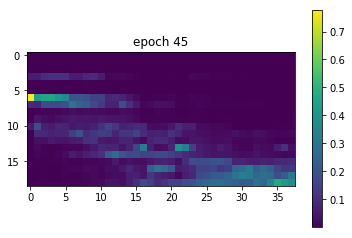

minibatch loop: 100%|██████████| 88/88 [00:14<00:00,  6.36it/s, cost=0.528, loss1=0.0237, loss2=0.0235, loss_att=0.00133, loss_bd1=0.207, loss_bd2=0.272]


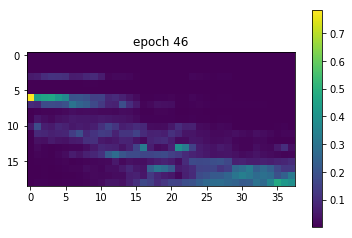

minibatch loop: 100%|██████████| 88/88 [00:14<00:00,  6.26it/s, cost=0.527, loss1=0.0236, loss2=0.0234, loss_att=0.0013, loss_bd1=0.207, loss_bd2=0.272] 


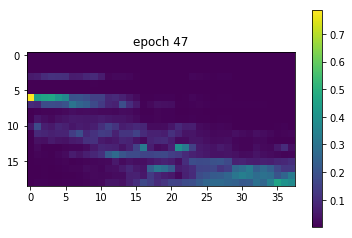

minibatch loop: 100%|██████████| 88/88 [00:14<00:00,  6.43it/s, cost=0.527, loss1=0.0234, loss2=0.0233, loss_att=0.00123, loss_bd1=0.207, loss_bd2=0.272]


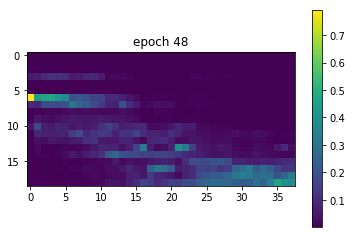

minibatch loop: 100%|██████████| 88/88 [00:14<00:00,  6.35it/s, cost=0.526, loss1=0.0233, loss2=0.0232, loss_att=0.00113, loss_bd1=0.207, loss_bd2=0.272]


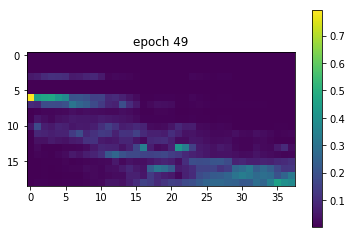

In [7]:
EPOCH = 50
for i in range(EPOCH):
    pbar = tqdm(range(0, len(paths), batch_size), desc = 'minibatch loop')
    for k in pbar:
        index = min(k + batch_size, len(paths))
        files, max_y, max_z = dynamic_batching(paths[k:index])
        max_x = max(lengths[k:index])
        batch_x = np.zeros((batch_size, max_x))
        batch_y = np.zeros((batch_size, max_y, n_mels * resampled))
        batch_z = np.zeros((batch_size, max_z, fourier_window_size // 2 + 1))
        for n in range(len(files)):
            batch_x[n, :] = np.pad(
                texts[k + n],
                ((0, max_x - texts[k + n].shape[0])),
                mode = 'constant',
            )
            batch_y[n, :, :] = np.pad(
                files[n][0],
                ((0, max_y - files[n][0].shape[0]), (0, 0)),
                mode = 'constant',
            )
            batch_z[n, :, :] = np.pad(
                files[n][1],
                ((0, max_z - files[n][1].shape[0]), (0, 0)),
                mode = 'constant',
            )
        _, cost, loss1, loss2, loss_bd1, loss_att, loss_bd2 = sess.run(
            [model.optimizer, model.loss, 
            model.loss1, model.loss2, model.loss_bd1,
            model.loss_att, model.loss_bd2],
            feed_dict = {model.X: batch_x, model.Y: batch_y, model.Z: batch_z},
        )
        pbar.set_postfix(cost = cost, loss1 = loss1, loss2 = loss2, loss_bd1 = loss_bd1,
                        loss_att = loss_att, loss_bd2 = loss_bd2)
        
    align = sess.run(
        model.alignments, feed_dict = {model.X: batch_x, model.Y: batch_y}
    )
    plot_alignment(align[0, :, :], i)

In [8]:
y_hat = np.ones((1, batch_y.shape[1], n_mels * resampled), np.float32)
max_attention = np.zeros((1), np.int32)
for j in tqdm(range(batch_y.shape[1])):
    _y_hat, attention = sess.run([model.test_Y_hat, model.max_attentions], 
                                 {model.X: [texts[0]], model.Y: y_hat,
                                  model.prev_max_attentions: max_attention})
    y_hat[:, j, :] = _y_hat[:, j, :]
    max_attention = attention[:, j]

100%|██████████| 38/38 [00:00<00:00, 84.42it/s]


In [9]:
mags = sess.run(model.Z_hat, {model.Y: y_hat})
audio = spectrogram2wav(mags[0])

In [10]:
import IPython.display as ipd
ipd.Audio(audio, rate = sample_rate)

In [11]:
from scipy.io.wavfile import write
print('saving: %s'%(raw_texts[0]))
write(os.path.join('test-dilated-cnn-monothonic-attention.wav'), sample_rate, audio)

saving: say the word burn


In [12]:
mags = sess.run(model.Z_hat, {model.Y: [batch_y[0]]})
audio = spectrogram2wav(mags[0])
ipd.Audio(audio, rate = sample_rate)

In [13]:
real_audio = spectrogram2wav(batch_z[0])
ipd.Audio(real_audio, rate = sample_rate)